In [1]:
import numpy as np
from scipy.optimize import minimize,basinhopping
import matplotlib.pyplot as plt

In [2]:
# Function definitions
def payload_i (x,y,beta_i):
    Hi=np.exp(-beta_i *y/x) -x**2 *(1-np.exp(-y/x))
    return Hi


def payload_mission(x,y,sequence):
    H_list=[]
    for beta_i in sequence:
        H_list.append(payload_i(x,y,beta_i))
    Hm=np.min(H_list)
    return Hm


def time_coeff (x,y,sequence):
    mp_refuel= np.sum(1-np.exp(-sequence *y/x))
    mp_star=1-np.exp(-y/x)
    tau=mp_refuel/mp_star
    return tau


def specific_fuel_cons(x,y,sequence):
    mp_refuel= np.sum(1-np.exp(-sequence *y/x))
    Hm=payload_mission(x,y,sequence)
    f=mp_refuel/Hm
    return f

In [3]:
def jacobian_tau(x,y,sequence):
    return (y/x)/(1-np.exp(-y/x))*np.exp(-sequence*y/x)


def taylored_tau(x,y,sequence):
    r=y/x
    mp_refuel= r-(1/2)*r**2*np.sum(sequence**2)+(1/6)*r**3*np.sum(sequence**3)-(1/24)*r**4*np.sum(sequence**4)
    mp_star=1-np.exp(-y/x)
    tau=mp_refuel/mp_star
    return tau



# Optimization of $H_m$ as a function of $n$

In [4]:
def opt_H(x,y,n):
    return np.exp(-(1/n) *y/x) -x**2 *(1-np.exp(-y/x))

def analytical_lim_H(x,y):
    return 1 -x**2 *(1-np.exp(-y/x))

In [5]:
y=0.5
x=1.2
n=np.arange(1,100,1)
H_opt=opt_H(x,y,n)
limit_H=analytical_lim_H(x,y)
limit_H

0.509306507488639

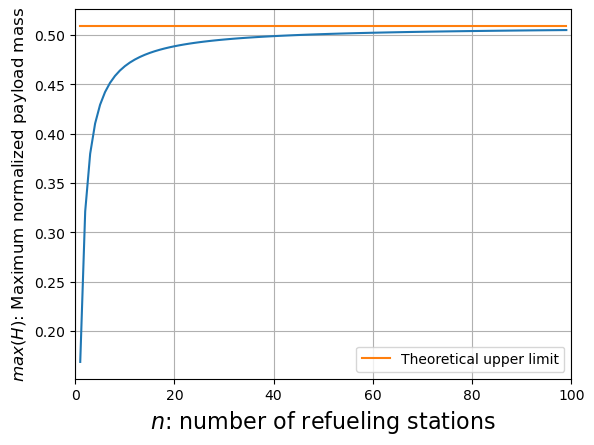

In [6]:
fig=plt.plot(figsize=(8,8))
plt.plot(n,H_opt)
plt.plot(np.array([n[0],n[-1]]),np.array([limit_H,limit_H]),label="Theoretical upper limit")

plt.xlabel(r'$n$: number of refueling stations',fontsize=16)  
plt.ylabel(r'$max(H)$: Maximum normalized payload mass',fontsize=12)   
plt.xlim([0,n[-1]+1])
plt.grid(True)
plt.legend(loc="lower right")
plt.savefig("figures/electric/H_vs_n.png")

# Optimization of $\tau$ as a function of $n$

In [7]:
def max_tau(x,y,n):
    return n*(1-np.exp(-(1/n)*y/x))/(1-np.exp(-y/x))

def analytical_lim_tau(x,y):
    return y/x/(1-np.exp(-y/x))

In [8]:
tau_max=max_tau(x,y,n)
limit_tau=analytical_lim_tau(x,y)

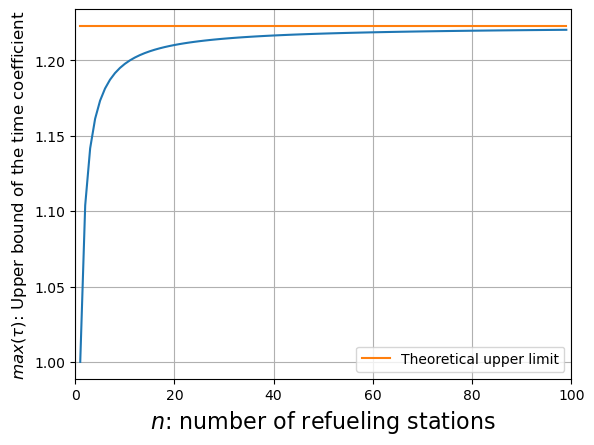

In [9]:
fig=plt.plot(figsize=(8,8))
plt.plot(n,tau_max)
plt.plot(np.array([n[0],n[-1]]),np.array([limit_tau,limit_tau]),label="Theoretical upper limit")

plt.xlabel(r'$n$: number of refueling stations',fontsize=16)  
plt.ylabel(r'$max(\tau)$: Upper bound of the time coefficient',fontsize=12)   
plt.xlim([0,n[-1]+1])
plt.grid(True)
plt.legend(loc="lower right")
plt.savefig("figures/electric/tau_vs_n.png")

# Optimization under constraints

In [10]:
# Constraint functions

def constraint_sum_beta(sequence):
    return np.sum(sequence) - 1

def constraint_payload_min(x, y, sequence, H_min):
    return payload_mission(x, y, sequence) - H_min

def constraint_tau_max(x, y,sequence, tau_max):
    return tau_max - time_coeff(x, y, sequence)

def constraint_f_max( x, y,sequence, f_max):
    return f_max - specific_fuel_cons(x, y, sequence)

In [11]:
y=0.5
x=1.2
H_max=opt_H(x,y,n)
H_min = 0.80*H_max
tau_max = 1.2
f_max = 1.2
n = 5
beta_initial = np.random.rand(n)
beta_initial= beta_initial/np.sum(beta_initial)

bounds = [(0, 1)] * n

# Constraints with parameters
constraints = [
    {'type': 'eq', 'fun': constraint_sum_beta},
    {'type': 'ineq', 'fun': lambda beta: constraint_payload_min(x, y,beta, H_min)},
    {'type': 'ineq', 'fun': lambda beta: constraint_f_max( x, y,beta, f_max)},
]

print("H_max=",H_max)

H_max= [0.16854714 0.32124285 0.37963123 0.41038161 0.42935092 0.44221847
 0.45151961 0.45855627 0.46406554 0.46849596 0.47213615 0.47518018
 0.47776342 0.47998313 0.48191098 0.483601   0.48509463 0.48642422
 0.48761539 0.48868869 0.48966078 0.49054534 0.49135367 0.49209523
 0.49277796 0.49340859 0.49399287 0.49453573 0.49504142 0.49551362
 0.49595557 0.49637008 0.49675962 0.49712639 0.49747233 0.49779916
 0.49810842 0.49840149 0.49867962 0.49894391 0.49919537 0.49943492
 0.49966338 0.49988151 0.50008998 0.50028944 0.50048044 0.50066352
 0.50083916 0.5010078  0.50116986 0.5013257  0.50147569 0.50162015
 0.50175937 0.50189364 0.50202322 0.50214834 0.50226924 0.50238612
 0.50249918 0.50260861 0.50271457 0.50281724 0.50291675 0.50301326
 0.5031069  0.50319779 0.50328606 0.50337181 0.50345515 0.50353618
 0.503615   0.5036917  0.50376636 0.50383905 0.50390987 0.50397887
 0.50404613 0.50411171 0.50417568 0.50423809 0.50429901 0.50435847
 0.50441654 0.50447326 0.50452869 0.50458285 0.5046358 

In [12]:
beta_initial = np.full(n, 1/n)
result = minimize(
    lambda beta: time_coeff(x, y, beta),
    beta_initial,
    method='SLSQP',
    jac= lambda beta: jacobian_tau(x,y,beta),
    constraints=constraints,
    bounds=bounds,
    options={'maxiter': 1000, 'disp': True}
)

# Results
if result.success:
    print(f"Optimal sequence: {[f'{beta:.3f}' for beta in result.x]}")
    print(f"Payload mission: {payload_mission(x, y, result.x):.3f}")
    print(f"Time coeff: {time_coeff(x, y, result.x):.3f}")
    print(f"Specific fuel cons: {specific_fuel_cons(x, y, result.x):.3f}")
else:
    print("Optimization failed:", result.message)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.1731971657552471
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1
Optimal sequence: ['0.200', '0.200', '0.200', '0.200', '0.200']
Payload mission: 0.429
Time coeff: 1.173
Specific fuel cons: 0.931


In [13]:
beta_initial = np.array([1,0,0,0,0])
result = minimize(
    lambda beta: time_coeff(x, y, beta),
    beta_initial,
    method='SLSQP',
    jac= lambda beta: jacobian_tau(x,y,beta),
    constraints=constraints,
    bounds=bounds,
    options={'maxiter': 1000, 'disp': True}
)

# Results
if result.success:
    print(f"Optimal sequence: {[f'{beta:.3f}' for beta in result.x]}")
    print(f"Payload mission: {payload_mission(x, y, result.x):.3f}")
    print(f"Time coeff: {time_coeff(x, y, result.x):.3f}")
    print(f"Specific fuel cons: {specific_fuel_cons(x, y, result.x):.3f}")
else:
    print("Optimization failed:", result.message)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.161228218049259
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 5
Optimal sequence: ['0.000', '0.250', '0.251', '0.250', '0.249']
Payload mission: 0.410
Time coeff: 1.161
Specific fuel cons: 0.965


In [14]:

iterations=5000
n=10
bounds = [(0, 1)] * n

tau_values=[]

np.seed=567
for i in range(iterations):


    beta_initial = np.random.rand(n)
    beta_initial= beta_initial/np.sum(beta_initial)
            
            
    result = minimize(
    lambda beta: time_coeff(x, y, beta),
    beta_initial,
    method='SLSQP',
    jac= lambda beta: jacobian_tau(x,y,beta),
    constraints=constraints,
    bounds=bounds,
    options={'maxiter': 1000, 'disp': False}
)   
    
    tau_values.append(time_coeff(x, y, result.x))


    

KeyboardInterrupt: 

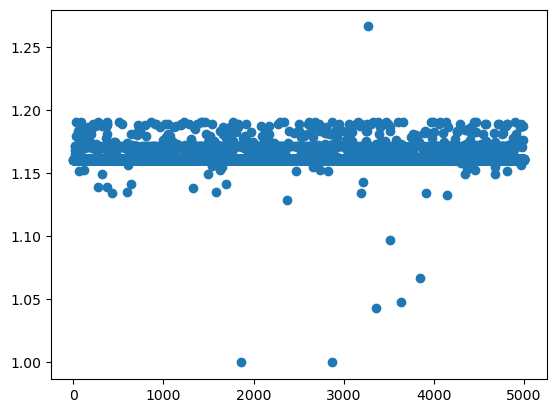

In [41]:
plt.scatter(np.arange(1,iterations+1),tau_values)

# Basin-hopping

In [15]:
y=0.4
x=1.2
H_max=opt_H(x,y,n)
H_min = 0.95*H_max
tau_max = 1.2
f_max = 1
n = 10
beta_initial = np.random.rand(n)
beta_initial= beta_initial/np.sum(beta_initial)
bounds = [(0, 1)] * n

In [16]:
H_max

0.5590211877082625

In [17]:
H_min

0.5310701283228493

In [18]:
# Define the local optimizer function to be used by basinhopping
def local_minimizer(beta):
    return minimize(
        lambda beta: time_coeff(x, y, beta),
        beta,
        method='SLSQP',
        jac=lambda beta: jacobian_tau(x, y, beta),
        constraints=constraints,
        bounds=bounds,
        options={'maxiter': 1000, 'disp': False}
    )
    
    
# Set up the basinhopping optimizer
minimizer_kwargs = {
    'method': 'SLSQP',  # Using SLSQP for constraints
    'constraints': constraints,
    'bounds': bounds
}

In [19]:
result = basinhopping(
    lambda beta: time_coeff(x, y, beta),  # Objective function
    beta_initial,  # Initial guess
    minimizer_kwargs=minimizer_kwargs,  # Local optimizer settings
    niter=200,  # Number of iterations for basinhopping
    stepsize=0.05,  # Step size for random hopping
    T=0.1,  # Temperature for accepting worse solutions
    disp=False  # Display progress
)

In [20]:
print(f"Optimal sequence: {[f'{beta:.3f}' for beta in result.x]}")
print(f"Payload mission: {payload_mission(x, y, result.x):.3f}")
print(f"Time coeff: {time_coeff(x, y, result.x):.3f}")
print(f"Specific fuel cons: {specific_fuel_cons(x, y, result.x):.3f}")

Optimal sequence: ['0.000', '0.188', '0.188', '0.060', '0.000', '0.000', '0.188', '0.188', '0.000', '0.188']
Payload mission: 0.531
Time coeff: 1.141
Specific fuel cons: 0.609


In [174]:
iterations=50
results=[]
for i in range(iterations):
    beta_initial = np.random.rand(n)
    beta_initial= beta_initial/np.sum(beta_initial)
    
    result = basinhopping(
    lambda beta: time_coeff(x, y, beta),  # Objective function
    beta_initial,  # Initial guess
    minimizer_kwargs=minimizer_kwargs,  # Local optimizer settings
    niter=200,  # Number of iterations for basinhopping
    stepsize=0.1,  # Step size for random hopping
    disp=False  # Display progress
)
    results.append(result.fun)
    

(1.0, 1.2)

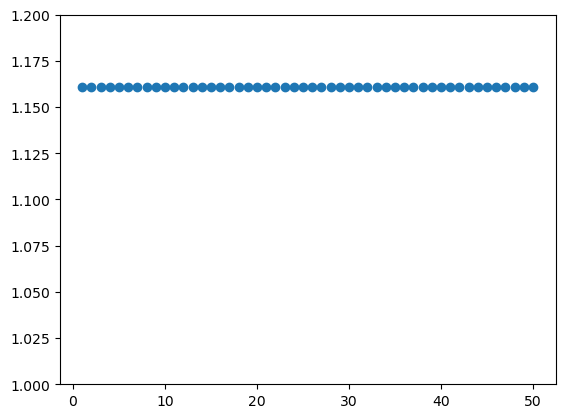

In [67]:
plt.scatter(np.arange(1,np.size(results)+1),results)
plt.ylim([1,1.2])

# Tests

In [74]:
y=0.4
x=2

In [75]:
sequence=np.array([1])
print(payload_mission(x,y,sequence))
print(time_coeff (x,y,sequence))
print(specific_fuel_cons(x,y,sequence))

0.0936537653899091
1.0
1.9355254555685955


In [76]:
n=10000
sequence=1/n*np.ones(n)
print(payload_mission(x,y,sequence))
print(time_coeff (x,y,sequence))
print(specific_fuel_cons(x,y,sequence))

0.27490301251192595
1.1033200799879537
0.7275220383577311


array([1.12499281, 1.03504335, 1.07908124, 1.17285777])